In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.utils import resample

%matplotlib inline

import logging

import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
#from pytorch_lightning.loggers import TensorBoardLogger
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime


In [2]:
df = pd.read_csv("WISDM_ar_v1.1_raw.txt", sep = ' ', header = None)

df['lenght'] = df[0].apply(lambda x: x.split(',')).apply(lambda x: len(x))
filtred_df = df[~df['lenght'].isin([7, 11])]
filtred_df[0] = filtred_df[0].apply(lambda x: x.split(','))

columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
for i, el in enumerate(columns):
  if i != len(columns)-1:
    filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i])
  else:
    filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i][:-1])

filtred_df = filtred_df.drop(columns = [0, 'lenght', 'timestamp'])

C:\Users\Katya\AppData\Local\Temp\ipykernel_3120\379243730.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_df[0] = filtred_df[0].apply(lambda x: x.split(','))
C:\Users\Katya\AppData\Local\Temp\ipykernel_3120\379243730.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i])
C:\Users\Katya\AppData\Local\Temp\ipykernel_3120\379243730.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [3]:
le = preprocessing.LabelEncoder()
filtred_df['activity'] = le.fit_transform(filtred_df['activity'])

def transform(x):
  try:
    x = float(x)
  except ValueError:
    x = np.nan
  return x

for el in filtred_df.columns:
  filtred_df[el] = filtred_df[el].apply(lambda x: transform(x))

In [4]:
for col in ['x-axis', 'y-axis', 'z-axis']:
  mean_value = filtred_df[col].mean()
  sigma = filtred_df[col].std()
  filtred_df[col] = filtred_df[col].apply(lambda x: (x-mean_value)/sigma)

In [5]:
def group_by_user(df, user):
  return df[df['user'] == user].reset_index(drop = True)

def create_window(df, overlay, window_size, train_x, train_y):
  for i in range(0, df.shape[0], overlay):
    df_sub = df.iloc[i:i+window_size]

    if df_sub.shape[0] == window_size:
      train_x.append(df_sub[['x-axis', 'y-axis', 'z-axis']].to_numpy())
      train_y.append(df_sub['activity'].mode().iloc[0])

  return train_x, train_y


In [6]:
train_x = []
train_y = []

window_size = 100
overlay = 50

users = filtred_df['user'].unique().tolist()[:12]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, train_x, train_y)

print (len(train_x), len(train_y))

7968 7968


In [7]:
test_x = []
test_y = []

users = filtred_df['user'].unique().tolist()[12:18]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, test_x, test_y)

print (len(test_x), len(test_y))

3381 3381


In [8]:
control_x = []
control_y = []

users = filtred_df['user'].unique().tolist()[18:32]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, control_x, control_y)

print (len(control_x), len(control_y))

8067 8067


In [9]:
train_dataset = TensorDataset(torch.tensor(np.array(train_x), dtype=torch.float32), torch.tensor(np.array(train_y).reshape(-1, 1), dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, drop_last = True)

test_dataset = TensorDataset(torch.tensor(np.array(test_x), dtype=torch.float32), torch.tensor(np.array(test_y).reshape(-1, 1), dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last = True)

control_dataset = TensorDataset(torch.tensor(np.array(control_x), dtype=torch.float32), torch.tensor(np.array(control_y).reshape(-1, 1), dtype=torch.float32))
control_loader = DataLoader(control_dataset, batch_size=256, shuffle=False, drop_last = True)

In [10]:
for inputs, labels in train_loader:
  print (inputs.shape, labels.shape)
  break

torch.Size([256, 100, 3]) torch.Size([256, 1])


In [11]:
for inputs, labels in test_loader:
  print (inputs.shape, labels.shape)
  break

torch.Size([256, 100, 3]) torch.Size([256, 1])


In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, batch_size):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.layer_dim = layer_dim

        self.rnn = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.randn(self.layer_dim, self.batch_size, self.hidden_dim, device=x.device).requires_grad_()
        c0 = torch.randn(self.layer_dim, self.batch_size, self.hidden_dim, device=x.device).requires_grad_()

        out, (h0, c0) = self.rnn(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_dim = 3, hidden_dim = 256, layer_dim = 3, output_dim = 6, dropout_prob = 0.3 , batch_size = 256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [14]:
def calculate_accuracy(y_true, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_true, y_pred_labels)
    return accuracy

In [16]:
import gc
train_losses = []
valid_losses = []
def train():

    running_loss = .0
    y_true = []
    y_pred_probs = []
    model.train()

    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        loss.backward()
        optimizer.step()
        running_loss += loss

        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'train_loss {train_loss}, train_accuracy {accuracy}')

    return train_losses

def valid():
    running_loss = .0
    y_true = []
    y_pred_probs = []
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds, labels.squeeze().long())
            
            if not loss.isnan():
              running_loss += loss
                
            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(preds.detach().cpu().numpy())

        valid_loss = running_loss/len(test_loader)
        valid_losses.append(valid_loss.detach().numpy())

        y_true = np.array(y_true)
        y_pred_probs = np.array(y_pred_probs)
        accuracy = calculate_accuracy(y_true, y_pred_probs)

        print(f'validation_loss {valid_loss}, validation_accuracy {accuracy}')
    return valid_losses, accuracy

epochs = 50
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    train_losses = train()
    valid_losses, _ = valid()
    gc.collect()

epochs 1/50
train_loss 1.738488793373108, train_accuracy 0.3467741935483871
validation_loss 1.5944926738739014, validation_accuracy 0.4636418269230769
epochs 2/50
train_loss 1.732499122619629, train_accuracy 0.3467741935483871
validation_loss 1.5878939628601074, validation_accuracy 0.4636418269230769
epochs 3/50
train_loss 1.725602626800537, train_accuracy 0.3467741935483871
validation_loss 1.580168604850769, validation_accuracy 0.4636418269230769
epochs 4/50
train_loss 1.7173653841018677, train_accuracy 0.3467741935483871
validation_loss 1.5707582235336304, validation_accuracy 0.4636418269230769
epochs 5/50
train_loss 1.707079291343689, train_accuracy 0.3467741935483871
validation_loss 1.5586577653884888, validation_accuracy 0.4636418269230769
epochs 6/50
train_loss 1.6935126781463623, train_accuracy 0.3467741935483871
validation_loss 1.5419280529022217, validation_accuracy 0.4636418269230769
epochs 7/50
train_loss 1.6737850904464722, train_accuracy 0.3467741935483871
validation_loss 

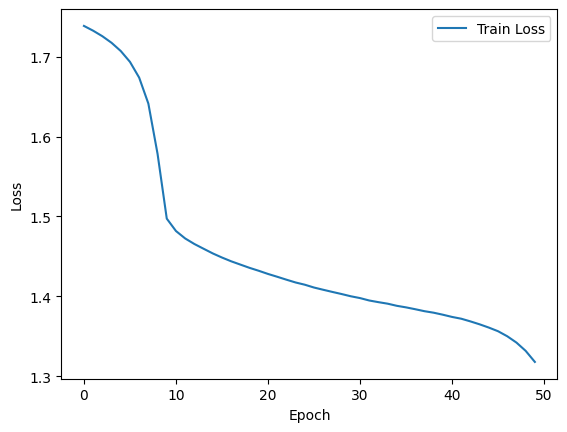

In [17]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

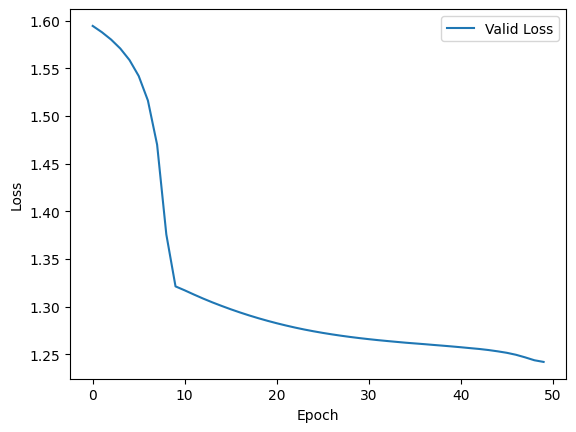

In [18]:
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
y_true = []
y_pred_probs = []
model.eval()

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(control_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    class_names = [str(x) for x in range(1,7)]
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f' control_accuracy {accuracy}')

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       802
           2       0.45      0.60      0.51      2413
           3       0.97      0.62      0.75       307
           4       0.00      0.00      0.00       359
           5       0.00      0.00      0.00      1080
           6       0.50      0.75      0.60      2975

    accuracy                           0.49      7936
   macro avg       0.32      0.33      0.31      7936
weighted avg       0.36      0.49      0.41      7936

 control_accuracy 0.4900453629032258


C:\Users\Katya\Documents\fastApi_Project\pythonProject1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Katya\Documents\fastApi_Project\pythonProject1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Katya\Documents\fastApi_Project\pythonProject1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [20]:
y_true = []
y_pred_probs = []
model.eval()

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    class_names =[str(x) for x in range(1,7)]
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'test_accuracy {accuracy}')

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       331
           2       0.34      0.60      0.44       855
           3       0.00      0.00      0.00        92
           4       0.00      0.00      0.00       126
           5       0.00      0.00      0.00       379
           6       0.52      0.62      0.57      1545

    accuracy                           0.44      3328
   macro avg       0.14      0.20      0.17      3328
weighted avg       0.33      0.44      0.37      3328

test_accuracy 0.44080528846153844


C:\Users\Katya\Documents\fastApi_Project\pythonProject1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Katya\Documents\fastApi_Project\pythonProject1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Katya\Documents\fastApi_Project\pythonProject1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [40]:
y_true = []
y_pred_probs = []
model.eval()

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    class_names = [str(x) for x in range(1,7)]
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'train_accuracy {accuracy}')

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       741
           2       0.01      0.00      0.00      2586
           3       0.00      0.00      0.00       662
           4       0.00      0.00      0.00       378
           5       0.00      0.00      0.00       817
           6       0.37      1.00      0.54      2752

    accuracy                           0.35      7936
   macro avg       0.06      0.17      0.09      7936
weighted avg       0.13      0.35      0.19      7936

train_accuracy 0.3471522177419355


C:\Users\Katya\Documents\fastApi_Project\pythonProject1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Katya\Documents\fastApi_Project\pythonProject1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Katya\Documents\fastApi_Project\pythonProject1\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [ ]:
Ы